# Entity Resolution- Dedupe Model

In [37]:
# Import Statements
from __future__ import print_function
from future.builtins import next

import os
import csv
import re
import collections
import numpy

import dedupe
from unidecode import unidecode

Setup

In [38]:
# the output_file will store the results of the record linkage deduplication
output_file = 'data_matching_output.csv'

# the settings file will contain the data model and predicates that determine matches
settings_file = 'data_matching_learned_settings'

# the training_file will contain the pairs of labeled examples that the model was trained on
training_file = 'data_matching_training.json'


In [39]:
# method to clean the data using Unidecode and Regex

def preProcess(column):
    # convert any unicode data into ASCII characters
    column = unidecode(column)
    # ignore new lines
    column = re.sub('\n', ' ', column)
    # ignore special characters
    column = re.sub('-', '', column)
    column = re.sub('/', ' ', column)
    column = re.sub("'", '', column)
    column = re.sub(",", '', column)
    column = re.sub(":", ' ', column)
    # ignore extra white space
    column = re.sub('  +', ' ', column)
    # ignore casing
    column = column.strip().strip('"').strip("'").lower().strip()
    if not column :
        column = None
    return column


In [40]:
# Read the data from the CSV and create a dictionary of addresses

def readData(filename):
    
    # initialize the dictionary
    data_d = {}

    # read each row in the CSV, clean the data, and it to a dictionary
    with open(filename) as f:
        reader = csv.DictReader(f)
        for i, row in enumerate(reader):
            clean_row = dict([(k, preProcess(v)) for (k, v) in row.items()])
            # each address will have a unique ID consisting of the file name and a unique number
            data_d[filename + str(i)] = dict(clean_row)

    return data_d

In [41]:
# Import the data
data_1 = readData('companies_final.csv')
data_2 = readData('companies_final_users.csv')

Train the model

In [42]:
# if there already exists a settings_file (with the data model),
# create a Dedupe object (linker) that will load the saved settings
if os.path.exists(settings_file):
    print('reading from', settings_file)
    with open(settings_file, 'rb') as sf :
        # create a record link object for saved settings- pass the data model to it
        linker = dedupe.StaticRecordLink(sf)

# if there is no previously saved settings data, create it
else:
    # Define the fields the linker will pay attention to
    # Specifying fields refines the comparison methods so not each part of the record are compared equally
    # for example, dedupe will learn which of these fields have higher weights (more important in determining matches) by using regularized logistic regression
    # String types compared using affine gap string distance
    # Note- the address field is only for US addresses (uses usaddress package to split into components)
        # must have dedupe-variable-address installed to use this
    fields = [
        {'field' : 'name', 'type': 'String'},
        {'field' : 'addr', 'type': 'String'},
        {'field' : 'city', 'type': 'String'},
        {'field' : 'ctry', 'type': 'String'},
        {'field' : 'code', 'type': 'String'}
    ]
    
    # Create a new linker object
    linker = dedupe.RecordLink(fields)
    # To train the linker, feed it a sample of records.
    linker.sample(data_1, data_2, 15000)

    
    # If we have training data saved from a previous run of linker,
    # look for it and load it in.
    if os.path.exists(training_file):
        print('reading labeled examples from ', training_file)
        with open(training_file) as tf :
            linker.readTraining(tf)

    # ## Active learning
    # Dedupe will find the next pair of records
    # it is least certain about and ask for them to be labelled as matches
    # or not.
    print('starting active labeling...')

    # Label examples, add them to the training data, and update the mathcing model
    dedupe.consoleLabel(linker)

    linker.train()

    # When finished, save training data as labeled examples in the training_file
    with open(training_file, 'w') as tf :
        linker.writeTraining(tf)

    # Save weights and predicates.  If the settings file
    # exists, skip all the training and learning next time we run
    # this file.
    with open(settings_file, 'wb') as sf :
        linker.writeSettings(sf)

name : european centre for research & consultancy ltd
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : asity ltd.
addr : national house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

0/10 positive, 0/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished


starting active labeling...
n


name : digital inclusion technology group (iap) limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 6 mobile limited
addr : 30 city road
city : london
ctry : uk
code : None

0/10 positive, 1/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : inku consultants limited
addr : ground floor 1 bakers row
city : london
ctry : uk
code : ec1r 3db

name : archon development uk ltd
addr : suite a 6 honduras street
city : None
ctry : None
code : None

0/10 positive, 2/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : arctree consulting limited
addr : ground floor 1 bakers row
city : london
ctry : uk
code : ec1r 3db

name : arctous limited
addr : kemp house 152 city road
city : None
ctry : None
code : None

0/10 positive, 3/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : 1 tech ltd
addr : 57 charterhouse street
city : london
ctry : uk
code : ec1m 6ha

name : 1 tech ltd
addr : 57 charterhouse street
city : london
ctry : united kingdom
code : ec1m a

0/10 positive, 4/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : infodocs limited
addr : kemp house 152160 city road
city : london
ctry : uk
code : ec1v 2nx

name : atri services ltd
addr : kemp house 152
city : london
ctry : None
code : None

1/10 positive, 4/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, name), TfidfTextSearchPredicate: (0.8, name))
name : 1 minus 1 limited
addr : molex house the millennium centre crosby way
city : farnham|surrey
ctry : uk
code : gu9 7xx

name : amission ltd
addr : None
city : london
ctry : uk
code : ec1v 1lj

1/10 positive, 5/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : 40 50 media ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

1/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : 1 tech ltd
addr : 57 charterhouse street
city : london
ctry : uk
code : ec1m 6ha

name : 1 tech ltd
addr : 5723 charterhouse st
city : london
ctry : uk
code : ec1m 6ha

2/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : argus intelligence limited
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

name : argus intelligence limited
addr : 152 kemp house city road
city : london
ctry : america
code : ec1v 2nx

3/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : 4d data centres limited
addr : 30 city road
city : london
ctry : uk
code : ec1 2ab

name : data centres limited
addr : 30 city road
city : london
ctry : uk
code : ec1 2ab

4/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, name), TfidfTextSearchPredicate: (0.8, name))
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, addr), SimplePredicate: (wholeFieldPredicate, name))
name : 1 tech ltd
addr : 57 charterhouse street
city : london
ctry : uk
code : ec1m 6ha

name : 1 tech limited
addr : 57 charterhse street
city : london
ctry : u kingdom
code : ec1m 6ha

5/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (sortedAcronym, addr))
name : audeza ltd
addr : kemp house 152 city road
city : london
ctry : uk
code : ec1v 2nx

name : aud eza ltd
addr : kemp house 15 2 city road
city : lon don
ctry : uk
code : ec1v 2nx

6/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, name), SimplePredicate: (commonTwoTokens, name))
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, addr), TfidfTextSearchPredicate: (0.8, name))
name : mar it services ltd
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : atri services ltd
addr : kemp house 152
city : london
ctry : None
code : None

7/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (3, name), SimplePredicate: (twoGramFingerprint, addr))
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, name), SimplePredicate: (commonTwoTokens, name))
name : adcompass ltd.
addr : 68 sycamore street
city : london
ctry : uk
code : ec1y 0sw

name : adcompass ltd.
addr : 7 sycamore street
city : london
ctry : uk
code : None

8/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, name), SimplePredicate: (commonTwoTokens, name))
name : maxhill consulting ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : aaa consult ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4py

9/10 positive, 6/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, name), SimplePredicate: (commonTwoTokens, name))
INFO:dedupe.training:(LevenshteinSearchPredicate: (2, addr), SimplePredicate: (twoGramFingerprint, name))
name : 23 snaps limited
addr : 16 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : 23 snapshot limited
addr : 16 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

9/10 positive, 7/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : fenergo uk limited
addr : 200 aldersgate
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 uk limited
addr : 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

10/10 positive, 7/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, name), SimplePredicate: (sameSevenCharStartPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (tokenFieldPredicate, ctry), SimplePredicate: (twoGramFingerprint, name))
name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mob lim
addr : 30 cty road
city : london
ctry : None
code : ec1y 2ab

10/10 positive, 8/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : 2e2 uk limited
addr : 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 services limited
addr : 200 aldersgate aldersgate street
city : london
ctry : None
code : ec1a 4hd

11/10 positive, 8/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, name), SimplePredicate: (sameThreeCharStartPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (tokenFieldPredicate, ctry), SimplePredicate: (twoGramFingerprint, name))
name : 4getmobile limited
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

name : 4 get mobile lim
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

12/10 positive, 8/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : after the flood limited
addr : 140142 st. john street
city : london
ctry : uk
code : ec1v 4ub

name : after flood limited
addr : 141 st. john st.
city : london
ctry : uk
code : ec1v 4ub

13/10 positive, 8/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, name), SimplePredicate: (sameThreeCharStartPredicate, addr))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (tokenFieldPredicate, ctry), SimplePredicate: (twoGramFingerprint, name))
name : asity ltd
addr : international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : assert media solutios ltd
addr : international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

14/10 positive, 8/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (commonTwoTokens, addr))
INFO:dedupe.training:(SimplePredicate: (commonTwoTokens, code), SimplePredicate: (firstIntegerPredicate, name))
name : unyfy consulting limited
addr : c o golder baqa ground floor 1 bakers row
city : london
ctry : uk
code : ec1r 3db

name : 4 consulting limited
addr : 4 snow
city : london
ctry : uk
code : None

14/10 positive, 9/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : dc intelligence limited
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : argus intelligence limited
addr : 152 kemp house city road
city : london
ctry : america
code : ec1v 2nx

14/10 positive, 10/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : 4d data centres limited
addr : 30 city road
city : london
ctry : uk
code : ec1 2ab

name : data centres limited
addr : None
city : london
ctry : uk
code : ec1 2ab

14/10 positive, 11/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : better web solutions limited
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : a tech solutions limited
addr : kemp house 152160 city road
city : london
ctry : uk
code : ec1v 2nx

15/10 positive, 11/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), TfidfNGramSearchPredicate: (0.6, name))
INFO:dedupe.training:(SimplePredicate: (firstIntegerPredicate, name), SimplePredicate: (sameThreeCharStartPredicate, addr))
name : csvconsult ltd
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : a consult ltd
addr : 2nd floor 145157 saint john st
city : london
ctry : uk
code : ec1v 4py

15/10 positive, 12/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 6 mobile limited
addr : 30 city road
city : london
ctry : uk
code : None

15/10 positive, 13/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : real datacentres (emea) limited
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : data centres limited
addr : None
city : london
ctry : uk
code : ec1 2ab

16/10 positive, 13/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), TfidfNGramSearchPredicate: (0.6, name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
name : adform london limited
addr : gate house 1 st johns square
city : london
ctry : uk
code : ec1m 4dh

name : adfor london ltd
addr : gate hous 2 st john square
city : london
ctry : uk
code : ec1m 4dh

16/10 positive, 14/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : rank1 (south) limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

17/10 positive, 14/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (firstTokenPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, name), TfidfTextSearchPredicate: (0.4, addr))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (tokenFieldPredicate, ctry))
name : 4d data centres limited
addr : 30 city road
city : london
ctry : uk
code : ec1 2ab

name : 1 mob lim
addr : 30 cty road
city : london
ctry : None
code : ec1y 2ab

17/10 positive, 15/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : acturis limited
addr : courtyard suite 100 hatton garden
city : london
ctry : uk
code : ec1n 8nx

name : acturis corp.
addr : courtyard suite 100 hatton garden
city : london
ctry : uk
code : ec1n 8nx

17/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : asity ltd
addr : international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : asity ltd.
addr : national house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

18/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : absu limited
addr : third floor 111 charterhouse street
city : london
ctry : uk
code : ec1m 6aw

name : absu ltd.
addr : 111 charterhouse street
city : london
ctry : uk
code : ec1m 6aw

19/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (commonTwoTokens, name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (sameFiveCharStartPredicate, name))
name : baby beauty group ltd.
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : baby beaut grp limited
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

20/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (alphaNumericPredicate, addr), SimplePredicate: (sameFiveCharStartPredicate, name))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (commonTwoTokens, name))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
name : alchera technologies limited
addr : international house 24 holborn viaduct city of london
city : london
ctry : uk
code : ec1a 2bn

name : alchera tech limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

21/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : artaneon ltd
addr : artaneon ltd unit 36 8890 hatton garden
city : london
ctry : uk
code : ec1n 8pg

name : artaneon limited
addr : 98 hatton garden
city : london
ctry : uk
code : ec1n 8pg

22/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : digital inclusion technology group (iap) limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mob lim
addr : 30 cty road
city : london
ctry : None
code : ec1y 2ab

23/10 positive, 16/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, name), SimplePredicate: (tokenFieldPredicate, ctry))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (alphaNumericPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (tokenFieldPredicate, ctry))
name : universal research & consulting limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

23/10 positive, 17/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : business centric services group limited
addr : 130 old street
city : london
ctry : uk
code : ec1v 9bd

name : bcsg ltd
addr : 130 old street
city : london
ctry : uk
code : ec1v 9bd

23/10 positive, 18/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : alchemyworks ltd
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : alchera tech limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

23/10 positive, 19/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


p


name : business centric services group limited
addr : 130 old street
city : london
ctry : uk
code : ec1v 9bd

name : bcsg ltd
addr : 130 old street
city : london
ctry : uk
code : ec1v 9bd

23/10 positive, 18/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished


y


name : alchemyworks ltd
addr : kemp house 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : alchera tech limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

24/10 positive, 18/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, name), SimplePredicate: (tokenFieldPredicate, ctry))
INFO:dedupe.training:(SimplePredicate: (commonTwoTokens, code), SimplePredicate: (firstIntegerPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (hundredIntegerPredicate, name), SimplePredicate: (wholeFieldPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (tokenFieldPredicate, ctry))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (alphaNumericPredicate, addr))
name : glopay limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 19/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : oricle designs ltd
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : areza limited
addr : 24 holborn viaduct
city : london
ctry : usa
code : ec1a 2bn

24/10 positive, 20/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : riverside computing solutions ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 21/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : fenergo uk limited
addr : 200 aldersgate
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 limited
addr : 200 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

24/10 positive, 22/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : universal research & consulting limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 23/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : china great fire wall network limited
addr : 160 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

name : agoc digi prvt limited
addr : 160 city road
city : london
ctry : uk
code : ec1v 2nx

24/10 positive, 24/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : studiof creative ltd
addr : 1 charterhouse mews
city : london
ctry : uk
code : ec1m 6bb

name : bedbug studio ltd
addr : 1 charterhouse mews
city : london
ctry : uk
code : ec1m 6bb

24/10 positive, 25/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : decode digital ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 26/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : mcleod enterprises ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 27/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : nk it solutions limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 28/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : bradlink ltd
addr : 145157 st. john street
city : london|england
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 29/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : vce solutions limited
addr : bentima house 4th floor 168172 old street
city : london
ctry : uk
code : ec1v 9bp

name : agm solutions limited
addr : 152 kemp house cty rd
city : londn
ctry : uk
code : ec1v

24/10 positive, 30/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : lemon yeti media ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 31/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : meganetwork ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

24/10 positive, 32/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : streamess limited
addr : 160 city road kemp house
city : london
ctry : uk
code : ec1v 2nx

name : agoc digi prvt limited
addr : 160 city road
city : london
ctry : uk
code : ec1v 2nx

24/10 positive, 33/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : agile alliance limited
addr : 24 international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : agile methods alliance ltd
addr : 24 international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

24/10 positive, 34/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : kemling ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 34/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : friendshipuk ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 35/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : infoseco ltd
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

name : 4 get mobile lim
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

25/10 positive, 36/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : arka associates limited
addr : 24 international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : alchera tech limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

25/10 positive, 37/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : fenergo uk limited
addr : 200 aldersgate
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 services ltd
addr : 200 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

25/10 positive, 38/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : online secure ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 39/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : lenderwize limited
addr : 1 charterhouse mews
city : london
ctry : uk
code : ec1m 6bb

name : amleu software development uk limited
addr : 1 charterhouse mew
city : london
ctry : uk
code : ec1m 6bb

25/10 positive, 40/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : newgen technologies ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 41/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : legalsure ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 42/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : warwick computer repairs ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

25/10 positive, 43/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : huba digital limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

25/10 positive, 44/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : ab techsys ltd
addr : international house 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : abs tech ltd
addr : international hse 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

25/10 positive, 45/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


y


name : anytime around ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 45/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : metaluxo it security ltd
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : arka associates limited
addr : 24 international house holborn viaduct
city : london
ctry : africa
code : ec1a 2bn

26/10 positive, 46/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


(y)es / (n)o / (u)nsure / (f)inished / (p)revious


p


name : anytime around ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 45/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished


n


name : metaluxo it security ltd
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : arka associates limited
addr : 24 international house holborn viaduct
city : london
ctry : africa
code : ec1a 2bn

26/10 positive, 46/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : behind pixels ltd
addr : 152 city road kemp house
city : london
ctry : uk
code : ec1v 2nx

name : 4 get mobile lim
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 47/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : morse group limited
addr : 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 uk limited
addr : 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

26/10 positive, 48/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : argus intelligence limited
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

name : 4 get mobile lim
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 49/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : glopay limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 50/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : bioscitex ltd.
addr : 152 city rd
city : london
ctry : uk
code : ec1v 2nx

name : altiatech ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 51/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : clickuni ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 52/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : bowater data services limited
addr : 200 aldersgate
city : london
ctry : uk
code : ec1a 4hd

name : services limited
addr : 200 200 aldersgate aldersgate street
city : london
ctry : uk
code : ec1a 4hd

26/10 positive, 53/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : enro solutions limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 54/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : search magnet marketing ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 55/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : vero solutions limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : bedroom london limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

26/10 positive, 56/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : simple digital ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

name : altiatech ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 57/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : nerdability ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 58/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : mcleod enterprises ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 59/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : irateu ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

name : 4 get mobile lim
addr : 152 kemp house city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 60/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : procyon studios limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : bedroom london limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

26/10 positive, 61/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : crogtech ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 62/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : fan domains ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 63/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : ektbly ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 64/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : smartlogic schemaserver limited
addr : 200 aldersgate street
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 services limited
addr : 200 aldersgate aldersgate street
city : london
ctry : None
code : ec1a 4hd

26/10 positive, 65/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : gioass domains limited
addr : 1 charterhouse mews
city : london
ctry : uk
code : ec1m 6bb

name : bedbug studio ltd
addr : 1 charterhouse mews
city : london
ctry : uk
code : ec1m 6bb

26/10 positive, 66/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : import.io limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mob lim
addr : 30 cty road
city : london
ctry : None
code : ec1y 2ab

26/10 positive, 67/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : digipolis limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : bedroom london limited
addr : 15 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

26/10 positive, 68/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : diligence consulting limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 69/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : activon projects limited
addr : international house 24 holborn viaduct
city : city of london|london
ctry : uk
code : ec1a 2bn

name : active think limited
addr : kemp house 152 city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 70/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : transglobe trading corporation limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4py

name : aaa consult ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4py

26/10 positive, 71/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : areza limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : alchera tech limited
addr : 24 holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

26/10 positive, 72/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : goldfish digital media limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 73/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : decimal factor software limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 74/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : arka associates limited
addr : 24 international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

name : agile methods alliance ltd
addr : 24 international house holborn viaduct
city : london
ctry : uk
code : ec1a 2bn

26/10 positive, 75/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : fenergo uk limited
addr : 200 aldersgate
city : london
ctry : uk
code : ec1a 4hd

name : 2e2 services limited
addr : 200 aldersgate aldersgate street
city : london
ctry : None
code : ec1a 4hd

26/10 positive, 76/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : ayscio ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 77/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : total media marketing ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 78/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : add to cart ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 79/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : evori limited
addr : 16 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : 23 snapshot limited
addr : 16 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

26/10 positive, 80/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : import.io limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

26/10 positive, 81/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : brown paper consulting limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 82/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : rank1 (south) limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mob lim
addr : 30 cty road
city : london
ctry : None
code : ec1y 2ab

26/10 positive, 83/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : irateu ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

name : altiatech ltd
addr : 152 city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 84/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : lux repair ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 85/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : sun systems it services limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 86/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : anytime around ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 87/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : uk properties online limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4py

name : aaa consult ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4py

26/10 positive, 88/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : infyline limited
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 89/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : yesql solutions limited
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 90/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : conserp limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

name : 1 mobile limited
addr : 30 city road
city : london
ctry : uk
code : ec1y 2ab

26/10 positive, 91/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : evori limited
addr : 16 bowling green lane
city : london
ctry : uk
code : ec1r 0bd

name : 23 snaps lim
addr : 16 bowling grn lane
city : london
ctry : uk
code : ec1r 0bd

26/10 positive, 92/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : drp wickham consultancy limited
addr : 145157 st. john st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 93/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : united pixels ltd
addr : 145157 st. john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 94/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : online secure ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 95/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : rosendahl conceptkiosk ltd
addr : 1718 aylesbury street
city : london
ctry : uk
code : ec1r 0db

name : arubaclowwd limited...
addr : 1718 aylesbury street
city : london
ctry : uk
code : ec1r 0db

26/10 positive, 96/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : maxhill consulting ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 97/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : web kingdom limited
addr : 160 city road
city : london
ctry : uk
code : ec1v 2nx

name : agoc digi prvt limited
addr : 160 city road
city : london
ctry : uk
code : ec1v 2nx

26/10 positive, 98/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : brainshowcase ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 99/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : choice wheel ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 100/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : search magnet marketing ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : almara ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 101/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : pc it solutions limited
addr : 2nd floor 145157 st john street
city : london
ctry : uk
code : ec1v 4py

name : a consult ltd
addr : 2nd floor 145157 saint john st
city : london
ctry : uk
code : ec1v 4py

26/10 positive, 102/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


n


name : almaradix ltd
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

name : 40 50 media inc
addr : 145157 st john street
city : london
ctry : uk
code : ec1v 4pw

26/10 positive, 103/10 negative
Do these records refer to the same thing?
(y)es / (n)o / (u)nsure / (f)inished / (p)revious


f


Finished labeling
INFO:rlr.crossvalidation:using cross validation to find optimum alpha...
INFO:rlr.crossvalidation:optimum alpha: 1.000000, score 0.723743871716687
INFO:dedupe.training:Final predicate set:
INFO:dedupe.training:(SimplePredicate: (sameFiveCharStartPredicate, name), SimplePredicate: (tokenFieldPredicate, ctry))
INFO:dedupe.training:(SimplePredicate: (firstTokenPredicate, addr), SimplePredicate: (hundredIntegerPredicate, name))
INFO:dedupe.training:(LevenshteinSearchPredicate: (4, name), SimplePredicate: (alphaNumericPredicate, addr))
INFO:dedupe.training:(SimplePredicate: (commonThreeTokens, name), SimplePredicate: (tokenFieldPredicate, ctry))


Blocking

In [43]:
import itertools

# Split the data up into groups of records with some feature in common
# Only comparing the entries in these blocks reduces number of comparisons
# This is more useful with larger datasets- where we would use a representative sample rather than all the data
# 2 blocking methods- predicate blocks and index (using inverted index)
blocks = linker._blockData(data_1,data_2)

Calculate precision, recall, threshold

In [44]:
# the records will be duplicates
candidate_records = itertools.chain.from_iterable(linker._blockedPairs(blocks))

# Calculate the probability that pair of records are duplicates
probability = dedupe.core.scoreDuplicates(candidate_records,
                                           linker.data_model,
                                           linker.classifier,
                                           linker.num_cores)['score']

probability = probability.copy()
probability.sort()
probability = probability[::-1]

expected_dupes = numpy.cumsum(probability)

# Recall- TP/(TP + FN) - ability to find all interesting data points
recall = expected_dupes / expected_dupes[-1]
# Precision- TP/(TP + FP) - take the probability that the pairs are duplicates divided by the total number of duplicates
precision = expected_dupes / numpy.arange(1, len(expected_dupes) + 1)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records
INFO:dedupe.api:700 records
INFO:dedupe.api:800 records
INFO:dedupe.api:900 records


In [45]:
print("probability:", probability)
print("expected duplicates:", expected_dupes)
print("recall:",recall)
print("precision:",precision)

probability: [0.9948251  0.9948251  0.9931765  0.99304485 0.99173063 0.9883905
 0.9883905  0.9883905  0.9883905  0.9883905  0.9883905  0.9883905
 0.9883905  0.98804003 0.9873788  0.98647034 0.98646885 0.9862508
 0.9860561  0.9809557  0.97925377 0.9778507  0.97741115 0.9770269
 0.9757093  0.9754329  0.9728984  0.97285366 0.97269785 0.970473
 0.9681892  0.96528304 0.9606316  0.9603413  0.95893055 0.9577851
 0.95322657 0.95036256 0.949613   0.9490687  0.9473373  0.9459979
 0.94593084 0.9447019  0.9401474  0.9348475  0.93411744 0.9314679
 0.9250924  0.91552705 0.89935493 0.89715654 0.89547694 0.8953674
 0.8932752  0.8916884  0.87481594 0.8622452  0.85622835 0.8544338
 0.8544338  0.8452613  0.8315724  0.82122225 0.8159416  0.78728104
 0.78452414 0.77142525 0.7444748  0.7337996  0.7161845  0.6967714
 0.68585706 0.6801169  0.6609481  0.6601646  0.6524902  0.64252216
 0.6396925  0.6064909  0.5617057  0.5453662  0.49507254 0.42704228
 0.39925498 0.37743506 0.37225065 0.3306864  0.32770517 0.275

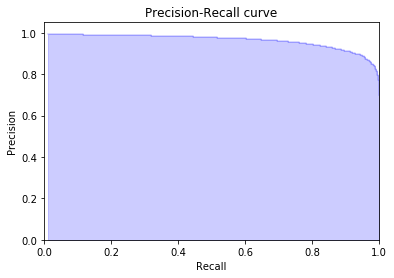

In [46]:
# Display the predicted precision-recall plot

from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


plt.step(recall, precision, color='b', alpha=.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve')
plt.show()

# PR curve looks nearly perfect due to small amounts of data

Clustering

In [47]:
# Find the threshold that will maximize a weighted average of our
# precision and recall (F Score) for a sample of data.  When we set the recall weight to 2, we are
# saying we care twice as much about recall as we do precision.
#
# The weighted avg, or F-score = 2tp/(2tp + fp + fn)
# 
# In this case, set the recall_weight to .5- saying we care twice as much about precision
# as we do recall. When matching the data, set the threshold closer to 1 to raise precision
# 
# This is called hierarchical clustering with centroid linkage
# Example- A is related to B, C is related to B, so those would all be clustered with B as centroid
# The threshold determines the minimum probability for a record to be related to the centroid

recall_weight = .9

score = recall * precision / (recall + recall_weight ** 2 * precision)

i = numpy.argmax(score)

print('Maximum expected recall and precision')
print('recall: %2.3f', recall[i])
print('precision: %2.3f', precision[i])
print('With threshold: %2.3f', probability[i])

calcThreshold= probability[i]

print("Threshold to maximize expected F score =", calcThreshold )


print('clustering...')
linked_records = linker.match(data_1, data_2, threshold=calcThreshold)

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records
INFO:dedupe.api:700 records
INFO:dedupe.api:800 records
INFO:dedupe.api:900 records


Maximum expected recall and precision
recall: %2.3f 0.94235754
precision: %2.3f 0.8905470313095465
With threshold: %2.3f 0.5453662
Threshold to maximize expected F score = 0.5453662
clustering...


In [48]:
print('# duplicate sets', len(linked_records))

# duplicate sets 60


Write results

In [49]:
# Write our original data back out to a CSV with a new column called 
# 'Cluster ID' which indicates which records refer to each other.

cluster_membership = {}
cluster_id = None
for cluster_id, (cluster, score) in enumerate(linked_records):
    for record_id in cluster:
        cluster_membership[record_id] = (cluster_id, score)

if cluster_id :
    unique_id = cluster_id + 1
else :
    unique_id =0

In [50]:
with open(output_file, 'w') as f:
    writer = csv.writer(f)
    
    header_unwritten = True

    for fileno, filename in enumerate(('company_addresses.csv', 'company_addresses_users.csv')) :
        with open(filename) as f_input :
            reader = csv.reader(f_input)

            if header_unwritten :
                heading_row = next(reader)
                heading_row.insert(0, 'source file')
                heading_row.insert(0, 'Link Score')
                heading_row.insert(0, 'Cluster ID')
                writer.writerow(heading_row)
                header_unwritten = False
            else :
                next(reader)

            for row_id, row in enumerate(reader):
                cluster_details = cluster_membership.get(filename + str(row_id))
                if cluster_details is None :
                    cluster_id = unique_id
                    unique_id += 1
                    score = None
                else :
                    cluster_id, score = cluster_details
                row.insert(0, fileno)
                row.insert(0, score)
                row.insert(0, cluster_id)
                writer.writerow(row)

In [94]:
name = input('Enter the company name: ')
addr = input('Enter the address: ')
city = input('Enter the city name: ')
ctry = input('Enter the country: ')
code = input('Enter the zip code: ')

# create a new file that will contain the user's entry
user_input_file = 'user_input_file.csv'
with open (user_input_file, 'w', newline='') as csvfile:
    fieldnames = ['id', 'name', 'addr', 'city', 'ctry', 'code']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({'id' : "1", 'name':name, 'addr': addr, 'city':city, 'ctry':ctry, 'code':code})
csvfile.close()

#AB TECHSYS LTD 	 INTERNATIONAL HOUSE 24 HOLBORN VIADUCT LONDON EC1A 2BN

Enter the company name: ab tech
Enter the address: internation house
Enter the city name: london
Enter the country: 
Enter the zip code: 


In [95]:
data_entry = readData('user_input_file.csv')

In [96]:
# now, need to update the settings file and training file when user enters a new address

In [108]:
try:
    match = linker.match(data_1, data_entry)
except dedupe.core.BlockingError:
     print("error!")
    

INFO:dedupe.api:0 records
INFO:dedupe.api:100 records
INFO:dedupe.api:200 records
INFO:dedupe.api:300 records
INFO:dedupe.api:400 records
INFO:dedupe.api:500 records
INFO:dedupe.api:600 records
INFO:dedupe.api:700 records
INFO:dedupe.api:800 records
INFO:dedupe.api:900 records


error!


In [88]:
# import pickle
# pickle.dump(readData, open("read_data_obj", 'wb'))

In [89]:
# x = pickle.load(open("read_data_obj",'rb'))

In [90]:
# x("company_addresses.csv")

In [98]:
id = int(data_1[match[0][0][0]]['id'])

In [99]:
with open('companies_final.csv', 'r') as my_file:
    reader = csv.reader(my_file)
    rows = list(reader)
    print (rows[id][1] + " " + rows[id][2])

AB TECHSYS LTD INTERNATIONAL HOUSE 24 HOLBORN VIADUCT
